In [1]:
import numpy as np
import matplotlib.pyplot as plt


class sm_transport:

    def __init__(self, Am, num_density, T, Z, units_out='star'):
        
        self.mi = Am
        if str(type(self.mi)) == "<class 'float'>" or str(type(self.mi)) == "<class 'int'>":
            self.mi = np.array([Am])

        self.Z = Z
        if str(type(self.Z)) == "<class 'float'>" or str(type(self.Z)) == "<class 'int'>":
            self.Z = np.array([Z])
            
        self.num_density = num_density
        if str(type(self.num_density)) == "<class 'float'>" or str(type(self.num_density)) == "<class 'int'>":
            self.num_density = np.array([num_density])
        
        self.T = T
        if str(type(self.T))== "<class 'float'>" or str(type(self.T)) == "<class 'int'>":
            self.T = np.array([T])

        self.e_squared = 1.4399644800e-7 # [ev cm]
        self.hbar = 6.5822958e-16 # reduced Planck's constant [eV*s]
        self.me = 9.1095e-28 # mass of electron [g]
        self.units_out = units_out
        
    def TF_Zbar(self, z, ni):

        '''
        Finite Temperature Thomas Fermi Charge State using 
        R.M. More, "Pressure Ionization, Resonances, and the
        Continuity of Bound and Free States", Adv. in Atomic 
        Mol. Phys., Vol. 21, p. 332 (Table IV).
        Z = atomic number
        num_density = number density (1/cc)
        T = temperature (eV)
        '''
        
        alpha = 14.3139
        beta = 0.6624
        a1 = 0.003323
        a2 = 0.9718
        a3 = 9.26148e-5
        a4 = 3.10165
        b0 = -1.7630
        b1 = 1.43175
        b2 = 0.31546
        c1 = -0.366667
        c2 = 0.983333

        convert = ni * 1.6726219e-24
        R = convert/z
        T0 = self.T/z**(4./3.)
        Tf = T0/(1 + T0)
        A = a1*T0**a2 + a3*T0**a4
        B = -np.exp(b0 + b1*Tf + b2*Tf**7)
        C = c1*Tf + c2
        Q1 = A*R**B
        Q = (R**C + Q1**C)**(1/C)
        x = alpha*Q**beta
        
        self.Zbar = z * x/(1 + x + np.sqrt(1 + 2*x))      

    def plasma_params(self, Z, ni, mi):

        self.TF_Zbar(Z, ni)

        self.ne = self.Zbar * ni # Compute electron number density [1/cm^3]

        self.ai = (4 * np.pi * ni/3)**(-1/3) # Wigner-Seitz radius [cm]
        
        self.gamma = self.Zbar**2 * self.e_squared/(self.ai * self.T) # Coulomb coupling parameter

        self.wp = np.sqrt(4 * np.pi * self.Zbar**2 * ni * self.e_squared/ mi * 1.60218e-12) # Plasma frequency [1/s]

        self.Ef = self.hbar**2/(2 * self.me) * (3 * np.pi**2 * self.ne)**(2/3) * 1.60218e-12 # fermi-energy [ev]

        self.lam_sq = ( self.T**(9/5) + (2/3*self.Ef)**(9/5) )**(5/9) / (4 * np.pi * self.ne * self.e_squared) # [cm]

        self.kappa = self.ai/np.sqrt(self.lam_sq) # inverse screening length # [1]

        self.g  = np.array(self.gamma * np.sqrt( self.kappa**2  + (3*self.gamma)/(1 + 3 * self.gamma) )) # Plasma parameter
        
        
    def Knm(self, g, n, m):

        if n and m == 1:
            a = np.array([1.4660, -1.7836, 1.4313, -0.55833, 0.061162])
            b = np.array([0.081033, -0.091336, 0.051760, -0.50026, 0.17044])
            
        if n and m == 2:
            a = np.array([0.85401, -0.22898, -0.60059, 0.80591, -0.30555])
            b = np.array([0.43475, -0.21147, 0.11116, 0.19665, 0.15195])
            
        Knm = np.zeros(len(self.g))
        for i in range(len(g)):
            g_arr = np.array([g[i], g[i]**2, g[i]**3, g[i]**4, g[i]**5])
        
            if g[i] < 1:
                Knm[i] = -n/4 * np.math.factorial(m - 1) * np.log( np.dot(a,g_arr) ) 
            else:
                Knm[i] = (b[0] + b[1]*np.log(g[i]) + b[2]*np.log(g[i])**2)/(1 + b[3]*g[i] + b[4]*g[i]**2)

        return Knm

    
    def self_diffusion(self):
        
        if len(self.num_density) == 1 and len(self.T) == 1 and len(self.Z) == 1:
            self.plasma_params(self.Z, self.num_density, self.mi)

            if self.units_out == 'star':
                self.D = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1))

            elif self.units_out == 'cgs':
                self.D = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1)) * self.wp * self.ai**2 

            else:
                print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs"')
                                              
        else:
            self.D = np.zeros([len(self.num_density), len(self.T), len(self.Z)])
        
            for k in range(len(self.Z)):
                for i in range(len(self.num_density)):
                    self.plasma_params(self.Z[k], self.num_density[i], self.mi[k])

                    if self.units_out == 'star':
                        self.D[i,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1))

                    elif self.units_out == 'cgs':
                        self.D[i,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1)) * self.wp * self.ai**2 

                    else:
                        print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs"')
                    
        return self.D
    
        
    def viscocity(self):
                                                 
        if len(self.num_density) == 1 and len(self.T) == 1 and len(self.Z) == 1:
                                              
            self.plasma_params(self.Z, self.num_density, self.mi)

            if self.units_out == 'star':
                self.eta = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )      

            elif self.units_out == 'cgs':
                self.eta = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) * self.mi * self.num_density * self.wp * self.ai**2 

            else:
                print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs"')
        else:
                                              
            self.eta = np.zeros([len(self.num_density), len(self.T), len(self.Z)])

            for k in range(len(self.Z)):
                for i in range(len(self.num_density)):
                    self.plasma_params(self.Z[k], self.num_density[i], self.mi[k])

                    if self.units_out == 'star':
                        self.eta[i,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )      

                    elif self.units_out == 'cgs':
                        self.eta[i,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) * self.mi[k] * self.num_density[i] * self.wp * self.ai**2 

                    else:
                        print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs"')
            
        return self.eta
        
    def thermal_conductivity(self):
        
        if len(self.num_density) == 1 and len(self.T) == 1 and len(self.Z) == 1:
        
                self.plasma_params(self.Z, self.num_density, self.mi)
        
                if self.units_out == 'star':
                    self.K = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )

                elif self.units_out == 'cgs':
                    self.K = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) * self.num_density * self.wp * self.ai**2 * 1.380649e-16 # eV K^{-1}
                else:
                    print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs"')                                      
                                              
        else:
                                              
            self.K = np.zeros([len(self.num_density), len(self.T), len(self.Z)])

            for k in range(len(self.Z)):
                for i in range(len(self.num_density)):
                    self.plasma_params(self.Z[k], self.num_density[i], self.mi[k])

                    if self.units_out == 'star':
                        self.K[i,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )

                    elif self.units_out == 'cgs':
                        self.K[i,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) * self.num_density[i] * self.wp * self.ai**2 * 1.380649e-16 # eV K^{-1}
                    else:
                        print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs"')
                    
        return self.K
    
    
    def plot(self, X, Y, xaxis='temeprature'):
        
        
        if xaxis == 'temperature':
        
            fig, ax = plt.subplots(nrows=1, ncols=len(self.Z), figsize=(30,8))
            for k in range(len(self.Z)):
                for i in range(len(self.num_density)):
                    ax[k].set_title(str(self.Z[k]))
                    ax[k].loglog(X, Y[i,:,k], '-o', linewidth=2)
                    # ax[0].loglog(T, D[len(T):], '-o', label='20 g/cc', linewidth=2)

                    ax[k].set_xlabel('Temperature', fontsize=20)
#                     ax[k].set_ylabel(self.label, fontsize=20)
                    ax[k].tick_params(axis="x", labelsize=14) 
                    ax[k].tick_params(axis="y", labelsize=14) 
#                     ax[k].legend(fontsize=18)


        if xaxis == 'density':
        
            fig, ax = plt.subplots(nrows=1, ncols=len(self.Z), figsize=(30,8))
            for k in range(len(self.Z)):
                for i in range(len(self.T)):
                    ax[k].set_title(str(self.Z[k]))
                    ax[k].loglog(X, Y[:,i,k], '-o', linewidth=2)
                    # ax[0].loglog(T, D[len(T):], '-o', label='20 g/cc', linewidth=2)

                    ax[k].set_xlabel('Density', fontsize=20)
#                     ax[k].set_ylabel(self.label, fontsize=20)
                    ax[k].tick_params(axis="x", labelsize=14) 
                    ax[k].tick_params(axis="y", labelsize=14) 
#                     ax[k].legend(fontsize=18)


In [10]:
# Multi-material Example
T = np.array([0.2, 2, 20, 2000])

Z = np.array([1, 6, 13]) 

rho_i = np.array([1, 100, 1000]) # mass density [g/cc]

Am = np.array([1.6735575e-24, 1.9944235e-23, 4.4803895e-23])  # atomic mass [g]

# # Multi-material Example
# T = 0.2

# Z = 1

# rho_i = 1

# Am = 1.6735575e-24

num_density = rho_i/Am
# print(num_density)


sm = sm_transport(Am, num_density, T, Z, units_out='cgs')

sm.self_diffusion()
sm.viscocity()
sm.thermal_conductivity()

array([[[2.57872145e+05, 3.54725114e+04, 2.02127514e+04],
        [3.25664543e+06, 2.38802992e+05, 1.20335185e+05],
        [6.14078540e+07, 2.09738707e+06, 8.70311672e+05],
        [2.51022716e+11, 2.40897949e+08, 3.05483449e+07]],

       [[4.72574777e+05, 6.82600325e+04, 3.91475591e+04],
        [4.74487263e+06, 4.11266085e+05, 2.12536285e+05],
        [9.63702074e+07, 3.24278183e+06, 1.38664651e+06],
        [3.05757051e+11, 4.51243292e+08, 7.81387069e+07]],

       [[8.10694533e+05, 1.17659314e+05, 6.70567618e+04],
        [7.26295511e+06, 6.75846261e+05, 3.50489010e+05],
        [1.26488427e+08, 4.89567788e+06, 2.14749045e+06],
        [3.61263429e+11, 7.91086695e+08, 1.58736628e+08]]])

In [13]:
import pandas as pd

d = {'Temp [eV]': [0.2, 2, 20, 2000], '$\langle Z\rangle$': sm.Zbar, '$D [cm^2s^{-1}]$': sm.D[0,:,0], '$\eta [g cm^{-1}s^{-1}]$': sm.eta[0,:,0], '$\kappa [erg/(cm * s * K)]$': sm.K[0,:,0]}

df = pd.DataFrame(data=d)
df


,Temp [eV],$\langle Z\rangle$,$D [cm^2s^{-1}]$,$\eta [g cm^{-1}s^{-1}]$,$\kappa [erg/(cm * s * K)]$
0,0.2,9.995495,0.001291,0.000834,2.578721e+05
1,2.0,9.995575,0.016792,0.010527,3.256645e+06
2,20.0,9.997433,0.316630,0.198495,6.140785e+07
3,2000.0,11.418914,1065.901004,811.407675,2.510227e+11


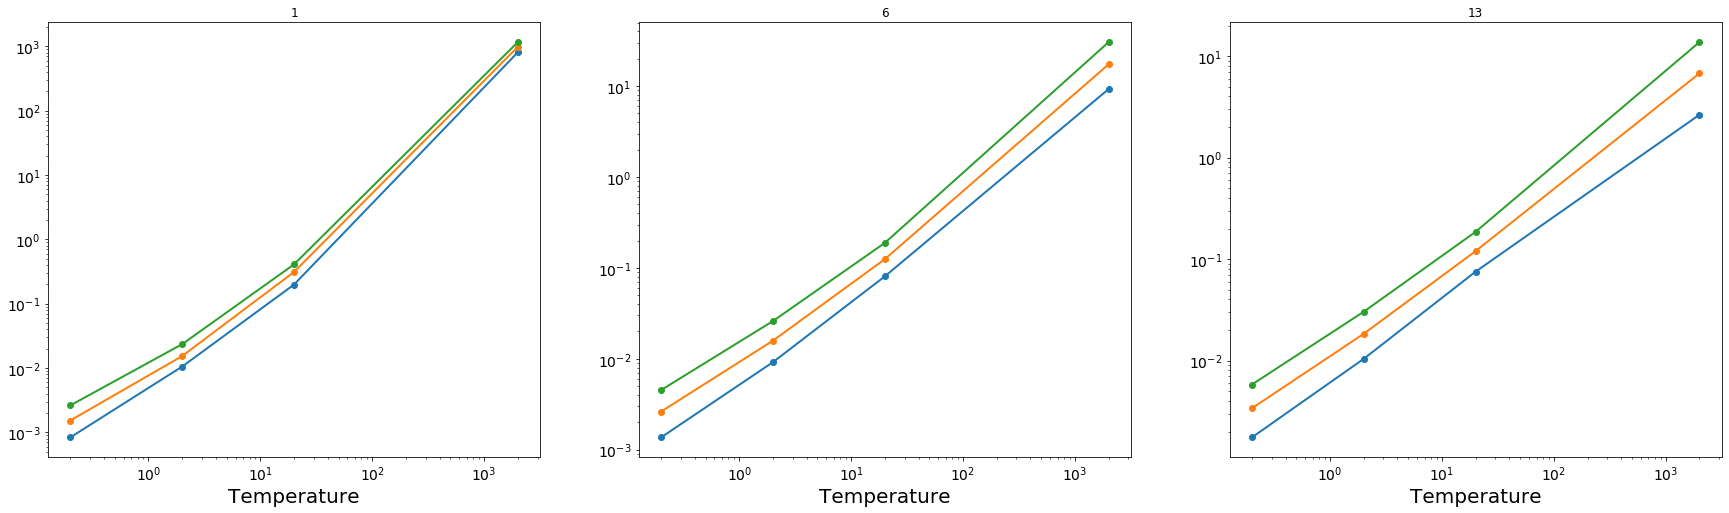

In [14]:
sm.plot(T, sm.eta, xaxis='temperature')

In [15]:
# Multi-material Example
T = 0.2

Z = 1

rho_i = 1

Am = 1.6735575e-24

num_density = rho_i/Am
# print(num_density)


sm = sm_transport(Am, num_density, T, Z, units_out='cgs')

sm.self_diffusion()
sm.viscocity()
sm.thermal_conductivity()

sm.eta
print(sm.eta[0])



0.0008335478214687808
